## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
from keras.layers import BatchNormalization
from keras.layers import Activation, Dense
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_v2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_v3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            x = Activation('relu')(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE =  [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [32]:
results1 = {}
for Bsize in BATCH_SIZE:
    keras.backend.clear_session()
    print("Experiment with BatchSize = %.0f" % (Bsize))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=Bsize, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-BatchSize-%s" % str(Bsize)
    results1[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with BatchSize = 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch 

50000/50000 [==============================] - 46s 918us/step - loss: 1.1592 - accuracy: 0.5882 - val_loss: 1.3687 - val_accuracy: 0.5269
Epoch 40/50
50000/50000 [==============================] - 46s 921us/step - loss: 1.1515 - accuracy: 0.5918 - val_loss: 1.3655 - val_accuracy: 0.5227
Epoch 41/50
50000/50000 [==============================] - 47s 938us/step - loss: 1.1485 - accuracy: 0.5918 - val_loss: 1.4132 - val_accuracy: 0.5074
Epoch 42/50
50000/50000 [==============================] - 46s 927us/step - loss: 1.1413 - accuracy: 0.5957 - val_loss: 1.3666 - val_accuracy: 0.5259
Epoch 43/50
50000/50000 [==============================] - 46s 912us/step - loss: 1.1353 - accuracy: 0.5945 - val_loss: 1.4177 - val_accuracy: 0.5066
Epoch 44/50
50000/50000 [==============================] - 46s 916us/step - loss: 1.1338 - accuracy: 0.5971 - val_loss: 1.3627 - val_accuracy: 0.5245
Epoch 45/50
50000/50000 [==============================] - 46s 920us/step - loss: 1.1260 - accuracy: 0.5995 - va

Epoch 34/50
50000/50000 [==============================] - 26s 513us/step - loss: 0.9112 - accuracy: 0.6750 - val_loss: 1.5592 - val_accuracy: 0.5051
Epoch 35/50
50000/50000 [==============================] - 25s 507us/step - loss: 0.9126 - accuracy: 0.6757 - val_loss: 1.5477 - val_accuracy: 0.4994
Epoch 36/50
50000/50000 [==============================] - 26s 511us/step - loss: 0.8946 - accuracy: 0.6811 - val_loss: 1.4889 - val_accuracy: 0.5119
Epoch 37/50
50000/50000 [==============================] - 26s 519us/step - loss: 0.8816 - accuracy: 0.6855 - val_loss: 1.6407 - val_accuracy: 0.4690
Epoch 38/50
50000/50000 [==============================] - 25s 507us/step - loss: 0.8802 - accuracy: 0.6859 - val_loss: 1.4734 - val_accuracy: 0.5153
Epoch 39/50
50000/50000 [==============================] - 25s 510us/step - loss: 0.8718 - accuracy: 0.6890 - val_loss: 1.4987 - val_accuracy: 0.5197
Epoch 40/50
50000/50000 [==============================] - 26s 515us/step - loss: 0.8620 - accuracy:

Epoch 29/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.5518 - accuracy: 0.8084 - val_loss: 2.0163 - val_accuracy: 0.4412
Epoch 30/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.5360 - accuracy: 0.8119 - val_loss: 1.9427 - val_accuracy: 0.4594
Epoch 31/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.5162 - accuracy: 0.8193 - val_loss: 2.0896 - val_accuracy: 0.4496
Epoch 32/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.5045 - accuracy: 0.8235 - val_loss: 2.2714 - val_accuracy: 0.4457
Epoch 33/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.4863 - accuracy: 0.8299 - val_loss: 1.9482 - val_accuracy: 0.4761
Epoch 34/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.4653 - accuracy: 0.8380 - val_loss: 2.2914 - val_accuracy: 0.4486
Epoch 35/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.4425 - accuracy:

Epoch 24/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.6531 - accuracy: 0.7814 - val_loss: 1.6914 - val_accuracy: 0.4838
Epoch 25/50
50000/50000 [==============================] - 7s 137us/step - loss: 0.6228 - accuracy: 0.7920 - val_loss: 1.7279 - val_accuracy: 0.4717
Epoch 26/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.5994 - accuracy: 0.8006 - val_loss: 1.7952 - val_accuracy: 0.4750
Epoch 27/50
50000/50000 [==============================] - 7s 137us/step - loss: 0.5714 - accuracy: 0.8103 - val_loss: 1.8136 - val_accuracy: 0.4643
Epoch 28/50
50000/50000 [==============================] - 7s 137us/step - loss: 0.5485 - accuracy: 0.8200 - val_loss: 1.8123 - val_accuracy: 0.4703
Epoch 29/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.5306 - accuracy: 0.8245 - val_loss: 1.7926 - val_accuracy: 0.4928
Epoch 30/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.5021 - accuracy: 0.8363

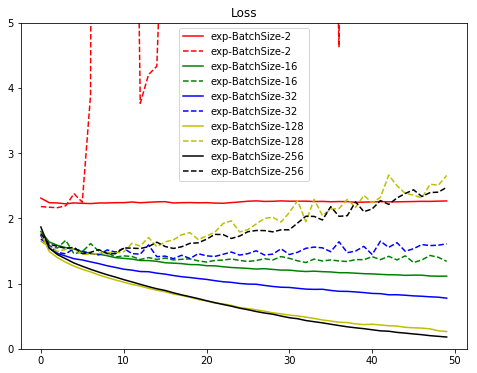

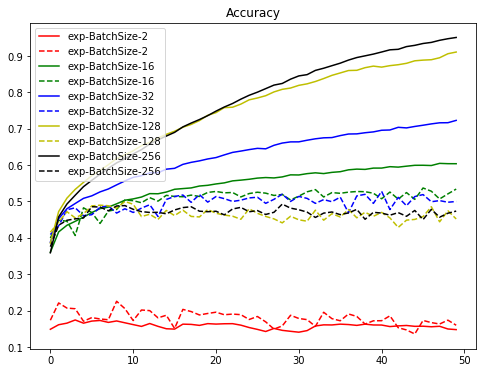

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "k"]

results = results1
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE =  [16, 32, 128, 256, 512]
MOMENTUM = 0.95

In [8]:
results2 = {}
for Bsize in BATCH_SIZE:
    keras.backend.clear_session()
    print("Experiment with BatchSize = %.0f" % (Bsize))
    model = build_mlp_v2(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=Bsize, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-BatchSize-V2-%s" % str(Bsize)
    results2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with BatchSize = 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)   

50000/50000 [==============================] - 47s 941us/step - loss: 0.5380 - accuracy: 0.8094 - val_loss: 1.7762 - val_accuracy: 0.5094
Epoch 44/50
50000/50000 [==============================] - 50s 996us/step - loss: 0.5327 - accuracy: 0.8118 - val_loss: 1.8703 - val_accuracy: 0.5157
Epoch 45/50
50000/50000 [==============================] - 45s 894us/step - loss: 0.5235 - accuracy: 0.8152 - val_loss: 1.9094 - val_accuracy: 0.4941
Epoch 46/50
50000/50000 [==============================] - 45s 904us/step - loss: 0.5190 - accuracy: 0.8174 - val_loss: 1.8920 - val_accuracy: 0.5145
Epoch 47/50
50000/50000 [==============================] - 52s 1ms/step - loss: 0.5070 - accuracy: 0.8219 - val_loss: 2.3841 - val_accuracy: 0.4506
Epoch 48/50
50000/50000 [==============================] - 48s 966us/step - loss: 0.4891 - accuracy: 0.8273 - val_loss: 1.8210 - val_accuracy: 0.5311
Epoch 49/50
50000/50000 [==============================] - 47s 932us/step - loss: 0.4895 - accuracy: 0.8270 - val_

50000/50000 [==============================] - 25s 502us/step - loss: 0.3421 - accuracy: 0.8786 - val_loss: 2.0432 - val_accuracy: 0.5021
Epoch 36/50
50000/50000 [==============================] - 25s 502us/step - loss: 0.3258 - accuracy: 0.8854 - val_loss: 2.3253 - val_accuracy: 0.4815
Epoch 37/50
50000/50000 [==============================] - 26s 520us/step - loss: 0.3233 - accuracy: 0.8862 - val_loss: 2.2828 - val_accuracy: 0.4878
Epoch 38/50
50000/50000 [==============================] - 25s 491us/step - loss: 0.3093 - accuracy: 0.8914 - val_loss: 2.1037 - val_accuracy: 0.5090
Epoch 39/50
50000/50000 [==============================] - 25s 491us/step - loss: 0.3018 - accuracy: 0.8923 - val_loss: 2.4119 - val_accuracy: 0.4828
Epoch 40/50
50000/50000 [==============================] - 25s 495us/step - loss: 0.2851 - accuracy: 0.9002 - val_loss: 2.2679 - val_accuracy: 0.5049
Epoch 41/50
50000/50000 [==============================] - 26s 513us/step - loss: 0.2866 - accuracy: 0.8978 - va

50000/50000 [==============================] - 9s 188us/step - loss: 0.2000 - accuracy: 0.9412 - val_loss: 2.3572 - val_accuracy: 0.4620
Epoch 28/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.1803 - accuracy: 0.9482 - val_loss: 2.5358 - val_accuracy: 0.4551
Epoch 29/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.1642 - accuracy: 0.9529 - val_loss: 2.2509 - val_accuracy: 0.4770
Epoch 30/50
50000/50000 [==============================] - 11s 215us/step - loss: 0.1550 - accuracy: 0.9564 - val_loss: 2.7186 - val_accuracy: 0.4449
Epoch 31/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.1424 - accuracy: 0.9604 - val_loss: 2.4801 - val_accuracy: 0.4679
Epoch 32/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.1329 - accuracy: 0.9634 - val_loss: 2.5623 - val_accuracy: 0.4431
Epoch 33/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.1285 - accuracy: 0.9635 - val

50000/50000 [==============================] - 7s 137us/step - loss: 0.5295 - accuracy: 0.8395 - val_loss: 1.7041 - val_accuracy: 0.4785
Epoch 20/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.4894 - accuracy: 0.8533 - val_loss: 2.0212 - val_accuracy: 0.4341
Epoch 21/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.4494 - accuracy: 0.8682 - val_loss: 1.8117 - val_accuracy: 0.4684
Epoch 22/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4136 - accuracy: 0.8820 - val_loss: 1.9278 - val_accuracy: 0.4687
Epoch 23/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.3791 - accuracy: 0.8929 - val_loss: 1.8335 - val_accuracy: 0.4715
Epoch 24/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.3443 - accuracy: 0.9061 - val_loss: 1.8934 - val_accuracy: 0.4730
Epoch 25/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.3127 - accuracy: 0.9175 - val_loss:

50000/50000 [==============================] - 7s 149us/step - loss: 1.1533 - accuracy: 0.6084 - val_loss: 1.4445 - val_accuracy: 0.4857
Epoch 12/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.1145 - accuracy: 0.6244 - val_loss: 1.4285 - val_accuracy: 0.4901
Epoch 13/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.0774 - accuracy: 0.6384 - val_loss: 1.4318 - val_accuracy: 0.4898
Epoch 14/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.0400 - accuracy: 0.6512 - val_loss: 1.4444 - val_accuracy: 0.4887
Epoch 15/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.0034 - accuracy: 0.6662 - val_loss: 1.4304 - val_accuracy: 0.4903
Epoch 16/50
50000/50000 [==============================] - 7s 131us/step - loss: 0.9689 - accuracy: 0.6777 - val_loss: 1.4360 - val_accuracy: 0.4926
Epoch 17/50
50000/50000 [==============================] - 7s 131us/step - loss: 0.9314 - accuracy: 0.6944 - val_loss:

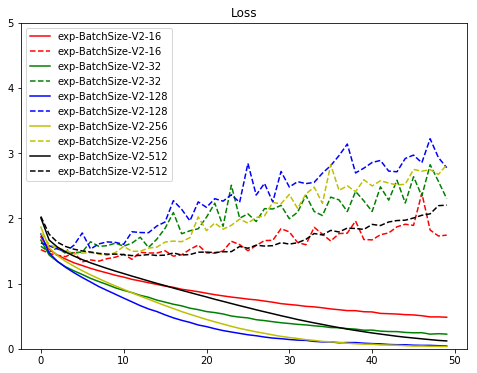

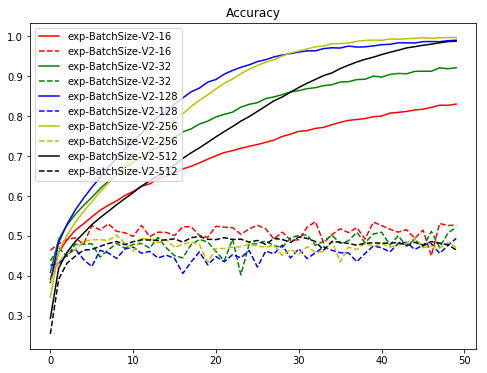

In [10]:
color_bar = ["r", "g", "b", "y", "k"]

results = results2
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
results3 = {}
for Bsize in BATCH_SIZE:
    keras.backend.clear_session()
    print("Experiment with BatchSize = %.0f" % (Bsize))
    model = build_mlp_v3(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=Bsize, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-BatchSize-V3-%s" % str(Bsize)
    results3[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with BatchSize = 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)       

50000/50000 [==============================] - 46s 919us/step - loss: 0.4171 - accuracy: 0.8508 - val_loss: 2.2134 - val_accuracy: 0.5017
Epoch 45/50
50000/50000 [==============================] - 46s 920us/step - loss: 0.4122 - accuracy: 0.8541 - val_loss: 2.0897 - val_accuracy: 0.5193
Epoch 46/50
50000/50000 [==============================] - 47s 931us/step - loss: 0.4003 - accuracy: 0.8590 - val_loss: 2.1096 - val_accuracy: 0.5220
Epoch 47/50
50000/50000 [==============================] - 45s 909us/step - loss: 0.3901 - accuracy: 0.8622 - val_loss: 2.1551 - val_accuracy: 0.5184
Epoch 48/50
50000/50000 [==============================] - 46s 928us/step - loss: 0.3824 - accuracy: 0.8638 - val_loss: 2.1359 - val_accuracy: 0.5174
Epoch 49/50
50000/50000 [==============================] - 46s 917us/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 2.1774 - val_accuracy: 0.5220
Epoch 50/50
50000/50000 [==============================] - 45s 892us/step - loss: 0.3689 - accuracy: 0.8691 - va

50000/50000 [==============================] - 24s 484us/step - loss: 0.2754 - accuracy: 0.9029 - val_loss: 2.3982 - val_accuracy: 0.5139
Epoch 38/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.2530 - accuracy: 0.9110 - val_loss: 2.5649 - val_accuracy: 0.4859
Epoch 39/50
50000/50000 [==============================] - 23s 467us/step - loss: 0.2547 - accuracy: 0.9106 - val_loss: 2.6271 - val_accuracy: 0.4779
Epoch 40/50
50000/50000 [==============================] - 24s 471us/step - loss: 0.2485 - accuracy: 0.9121 - val_loss: 2.5187 - val_accuracy: 0.5008
Epoch 41/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.2332 - accuracy: 0.9195 - val_loss: 2.7009 - val_accuracy: 0.4786
Epoch 42/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.2243 - accuracy: 0.9217 - val_loss: 2.7060 - val_accuracy: 0.4940
Epoch 43/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.2180 - accuracy: 0.9227 - va

50000/50000 [==============================] - 10s 200us/step - loss: 0.2456 - accuracy: 0.9209 - val_loss: 2.9051 - val_accuracy: 0.4281
Epoch 32/50
50000/50000 [==============================] - 9s 190us/step - loss: 0.2382 - accuracy: 0.9237 - val_loss: 2.5940 - val_accuracy: 0.4603
Epoch 33/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.2209 - accuracy: 0.9288 - val_loss: 2.7595 - val_accuracy: 0.4534
Epoch 34/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.1986 - accuracy: 0.9376 - val_loss: 3.7266 - val_accuracy: 0.4013
Epoch 35/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.1923 - accuracy: 0.9397 - val_loss: 2.6632 - val_accuracy: 0.4685
Epoch 36/50
50000/50000 [==============================] - 9s 190us/step - loss: 0.1797 - accuracy: 0.9430 - val_loss: 2.7390 - val_accuracy: 0.4695
Epoch 37/50
50000/50000 [==============================] - 10s 207us/step - loss: 0.1619 - accuracy: 0.9497 - val_los

50000/50000 [==============================] - 7s 130us/step - loss: 0.5279 - accuracy: 0.8307 - val_loss: 1.8207 - val_accuracy: 0.4768
Epoch 26/50
50000/50000 [==============================] - 7s 131us/step - loss: 0.4981 - accuracy: 0.8408 - val_loss: 1.7525 - val_accuracy: 0.4991
Epoch 27/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.4676 - accuracy: 0.8512 - val_loss: 2.1176 - val_accuracy: 0.4583
Epoch 28/50
50000/50000 [==============================] - 7s 131us/step - loss: 0.4375 - accuracy: 0.8615 - val_loss: 2.0251 - val_accuracy: 0.4763
Epoch 29/50
50000/50000 [==============================] - 7s 130us/step - loss: 0.4046 - accuracy: 0.8736 - val_loss: 2.0243 - val_accuracy: 0.4754
Epoch 30/50
50000/50000 [==============================] - 7s 131us/step - loss: 0.3791 - accuracy: 0.8834 - val_loss: 2.0452 - val_accuracy: 0.4742
Epoch 31/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.3516 - accuracy: 0.8947 - val_loss:

50000/50000 [==============================] - 6s 119us/step - loss: 1.0515 - accuracy: 0.6453 - val_loss: 1.3736 - val_accuracy: 0.5162
Epoch 20/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.0242 - accuracy: 0.6556 - val_loss: 1.4221 - val_accuracy: 0.4991
Epoch 21/50
50000/50000 [==============================] - 6s 112us/step - loss: 0.9974 - accuracy: 0.6646 - val_loss: 1.4343 - val_accuracy: 0.5014
Epoch 22/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.9685 - accuracy: 0.6754 - val_loss: 1.3847 - val_accuracy: 0.5229
Epoch 23/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.9409 - accuracy: 0.6856 - val_loss: 1.4543 - val_accuracy: 0.4986
Epoch 24/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.9140 - accuracy: 0.6951 - val_loss: 1.4507 - val_accuracy: 0.5087
Epoch 25/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.8888 - accuracy: 0.7046 - val_loss:

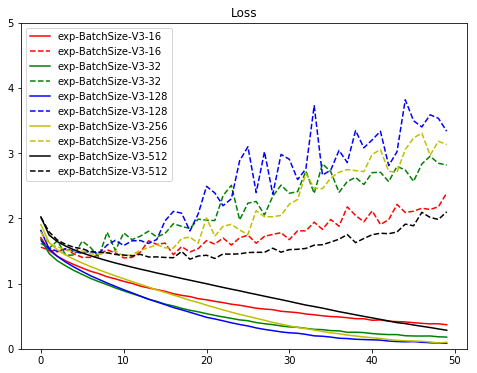

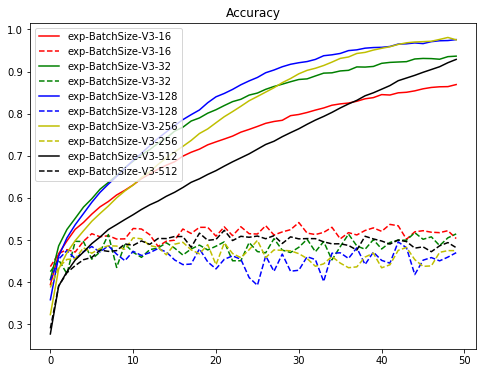

In [14]:
color_bar = ["r", "g", "b", "y", "k"]

results = results3
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()